# Sklearn

## sklearn.linear_model

В данном домашнем задании нужно использовать линейную регрессию и две регуляризации: Lasso (L1-регуляризация) и Ridge (L2-регуляризация).\
План решения задания:
* Проанализировать и подготовить данные (если нужно);
* Обучить модель;
* Посчитать качество (MAE);
* Сравнить полученные коэффициенты регуляризации.\
Регуляризация:
* Lasso (L1-регуляризация): $Loss = MSE + α∥w∥_1$
* Ridge(L2-регуляризация): $Loss = MSE + α∥w∥^2_2$

In [279]:
!pip -q install ydata-profiling

In [280]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

In [281]:
%matplotlib inline

### 1. Линейная регрессия

Линейная регрессия: $y^-=w_1*x_1+w_2*x_2+⋯+w_p*x_p+b$ \
где:\
w — веса (коэффициенты),\
b — свободный член (далее в работе он упоминается).

#### Генерация данных

In [282]:
data, target, coef = datasets.make_regression(n_features = 2, n_informative = 1, n_targets = 1, 
                                              noise = 5., coef = True, random_state = 2)

In [283]:
df = pd.DataFrame(data, columns=["x1", "x2"])
df["y"] = target
df.head()

,x1,x2,y
0,-1.134318,-0.707421,-45.385891
1,-0.276179,-0.516884,-10.295458
2,-0.462005,0.350888,-21.476069
3,0.365054,0.774082,11.961652
4,-1.021415,0.432396,-42.444696


Проведем анализ данных с помощью библиотеки ydata-profiling

In [284]:
type(data), getattr(data, "shape", None)

profile = ProfileReport(df, minimal=True, title="EDA report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 20068.44it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [285]:
df.info()
df.describe()
print("Пропуски:\n", df.isna().sum())
print("\nКорреляции:\n", df.corr(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   y       100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB
Пропуски:
 x1    0
x2    0
y     0
dtype: int64

Корреляции:
           x1        x2         y
x1  1.000000 -0.067831  0.993341
x2 -0.067831  1.000000 -0.060438
y   0.993341 -0.060438  1.000000


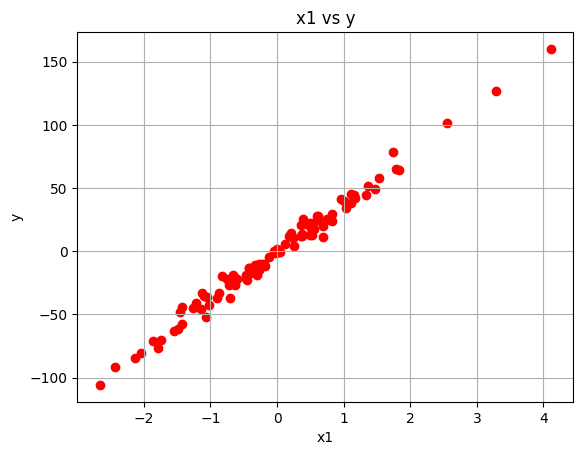

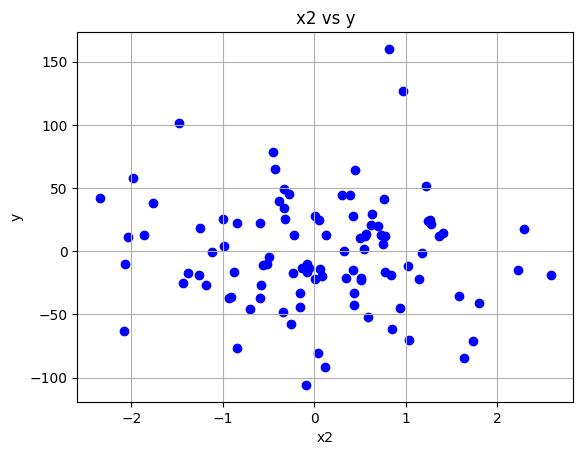

In [286]:
plt.figure()
plt.scatter(df["x1"], df["y"], color = 'r')
plt.xlabel("x1"); plt.ylabel("y"); plt.title("x1 vs y")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(df["x2"], df["y"], color = 'b')
plt.xlabel("x2"); plt.ylabel("y"); plt.title("x2 vs y")
plt.grid(True)
plt.show()

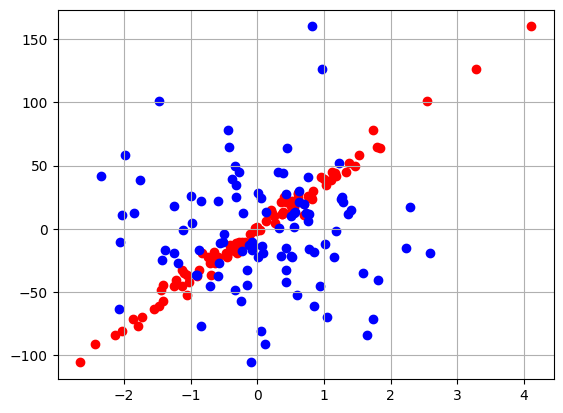

In [287]:
plt.scatter(data[:, 0], target, color = 'r')
plt.scatter(data[:, 1], target, color = 'b')
plt.grid(True)
plt.show()

Добавим random_state=42, чтобы было устойчивое сравнение моделей. Так как разбиение данных может быть разным при каждом запуске кода. 

In [288]:
train_data, test_data, train_labels, test_labels = train_test_split(data, target, 
                                                                    test_size = 0.3, random_state=42)

### 2. LinearRegression - обучение модели

In [289]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_data, train_labels)
predictions = linear_regressor.predict(test_data)

In [290]:
print (test_labels)

[  18.17188553  -44.51417742   23.87701013    4.45578287   41.95683853
   27.83791274  -18.57607726 -105.77758163  -70.11132234  -45.38589148
  -37.31870104   58.26281761   12.42286854   64.19559505   24.82763821
  -42.44469577  -10.06708677   12.74038341   14.76930132    5.86887774
    1.72644759   17.64282734  -36.44717565   -1.42235396  -10.27758354
  -18.86438755  -26.87743177  -22.33224966   39.70663436   44.41658249]


In [291]:
print (predictions)

[  17.80725117  -55.57960937   31.72281398    8.48431643   42.94631486
   22.95897004  -25.41072288 -103.19970295  -67.03829779  -44.87687396
  -35.87326642   56.95350861    6.4985028    70.12561806   30.74929314
  -39.83240058  -10.83854142    6.39388795    7.93785438    4.48374237
   -0.45151777   21.84595445  -42.06123737   -0.80026313   -8.12427028
  -19.57997191  -28.82547114  -29.56362568   37.48478394   44.15790857]


In [292]:
metrics.mean_absolute_error(test_labels, predictions)

3.5930362135852656

Если поставить в коде ниже "greater_is_better=True", то при подборе/оценке получится логика “больше MAE = лучше”, но нам нужно наоборот, чтобы для значения MAE было "чем меньше, тем лучше". Тогда логичнее рассматривать итоговые значения с противоположным знаком: -linear_scoring.mean(). \
Поэтому в ячейках ниже исправим код.

In [293]:
linear_scoring = cross_val_score(linear_regressor, train_data, train_labels, scoring = 'neg_mean_absolute_error', 
                                                  cv = 10)
print ('mean: {}, std: {}'.format(-linear_scoring.mean(), linear_scoring.std()))

mean: 4.324370689779501, std: 1.0472786940399672


In [294]:
#scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [295]:
#linear_scoring = cross_val_score(linear_regressor, train_data, train_labels, scoring='neg_mean_absolute_error', cv = 10)
#print ('mean: {}, std: {}'.format(-linear_scoring.mean(), linear_scoring.std()))

In [296]:
coef

array([38.07925837,  0.        ])

In [297]:
linear_regressor.coef_

array([38.48885295,  0.61320168])

In [298]:
# в лекции не указано, что в уравнении обученной модели также участвует свободный член b
linear_regressor.intercept_

np.float64(-0.784464991539292)

In [299]:
print ("y = {:.2f}*x1 + {:.2f}*x2".format(coef[0], coef[1]))

y = 38.08*x1 + 0.00*x2


In [300]:
print ("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(linear_regressor.coef_[0], 
                                                  linear_regressor.coef_[1], 
                                                  linear_regressor.intercept_))

y = 38.49*x1 + 0.61*x2 + -0.78


### 3. Lasso регуляризация

In [301]:
lasso_regressor = linear_model.Lasso(random_state = 3, max_iter=10000)
lasso_regressor.fit(train_data, train_labels)
lasso_predictions = lasso_regressor.predict(test_data)

In [302]:
lasso_scoring = cross_val_score(lasso_regressor, train_data, train_labels, scoring='neg_mean_absolute_error', cv = 10)
print ('mean: {}, std: {}'.format(-lasso_scoring.mean(), lasso_scoring.std()))

mean: 4.3109593563671575, std: 0.9989802733867044


In [303]:
print (lasso_regressor.coef_)

[37.73093662  0.        ]


In [304]:
print ("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(coef[0], coef[1], lasso_regressor.intercept_))

y = 38.08*x1 + 0.00*x2 + -0.73


In [305]:
print ("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(lasso_regressor.coef_[0], lasso_regressor.coef_[1], lasso_regressor.intercept_))

y = 37.73*x1 + 0.00*x2 + -0.73


Посчитаем MAE на тестовой выборке: 

In [306]:
metrics.mean_absolute_error(test_labels, lasso_predictions)

3.5578456623060313

### 4. Ridge регуляризация

In [307]:
ridge_regressor = linear_model.Ridge(random_state = 3)
ridge_regressor.fit(train_data, train_labels)
ridge_predictions = ridge_regressor.predict(test_data)

In [308]:
ridge_scoring = cross_val_score(ridge_regressor, train_data, train_labels, scoring='neg_mean_absolute_error', cv = 10)
print ('mean: {}, std: {}'.format(-ridge_scoring.mean(), ridge_scoring.std()))

mean: 4.389571797186576, std: 1.0585089169057305


In [309]:
print (ridge_regressor.coef_)

[38.09691066  0.56156556]


In [310]:
print ("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(coef[0], coef[1], ridge_regressor.intercept_))

y = 38.08*x1 + 0.00*x2 + -0.79


In [311]:
print ("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(ridge_regressor.coef_[0], ridge_regressor.coef_[1], ridge_regressor.intercept_))

y = 38.10*x1 + 0.56*x2 + -0.79


In [312]:
metrics.mean_absolute_error(test_labels, ridge_predictions)

3.6106862788654857

“По кросс-валидации (CV MAE) лучшая модель: …, её ошибка …”

“На тестовой выборке (test MAE) лучшая модель: …, ошибка …”

“Ridge (L2) уменьшает коэффициенты, но обычно не зануляет их.”

“Lasso (L1) может занулять коэффициенты: в нашем случае занулено n_zero_coef коэффициентов, то есть модель фактически отобрала признаки.”

“Так как в генерации данных n_informative=1, ожидаемо, что один признак неинформативный — Lasso должен стремиться занулить его вес.”

### 5. Подбор коэффициента регуляризации alpha для Lasso и Ridge